# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.metrics import accuracy_score

## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

In [2]:
df = pd.read_csv('../data/checker_submits.csv', parse_dates=['timestamp'])

In [3]:
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.weekday
df.drop(columns=['timestamp'], inplace=True)

In [4]:
encoder = OneHotEncoder(sparse_output=False)
columns_encoded = encoder.fit_transform(df[['uid', 'labname']])
feature_names = encoder.get_feature_names_out()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['numTrials', 'hour']])
df[['numTrials', 'hour']] = scaled_features

In [5]:
df = pd.concat([df, pd.DataFrame(columns_encoded, columns=feature_names)], axis=1)
df.drop(columns=['uid', 'labname'], inplace=True)

In [8]:
df.to_csv('../data/dayofweek.csv', index=False)

In [8]:
accuracy_score(df['weekday'], [df['weekday'].mode()] * len(df['weekday']))

0.23487544483985764

## 2. Algorithms

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

In [9]:
from sklearn.linear_model import LogisticRegression

features = df.drop(columns=['weekday'])
target = df['weekday']

In [13]:
model = LogisticRegression(
    fit_intercept=False,
    random_state=21,
    solver='liblinear'
)

model.fit(features, target)

/home/artem/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,False
,intercept_scaling,1
,class_weight,None
,random_state,21
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [14]:
accuracy_score(model.predict(features), target)

0.6215895610913404

In [8]:
def draw_barh(features, coefs):
    feature_indexes = np.argsort(coefs)[-10:]
    
    top_10_features = pd.DataFrame({
        'feature' : features[feature_indexes],
        'coef' : coefs[feature_indexes]
    })
    
    top_10_features.plot(kind='barh', x='feature', y='coef', figsize=(15, 8))

<Axes: ylabel='feature'>

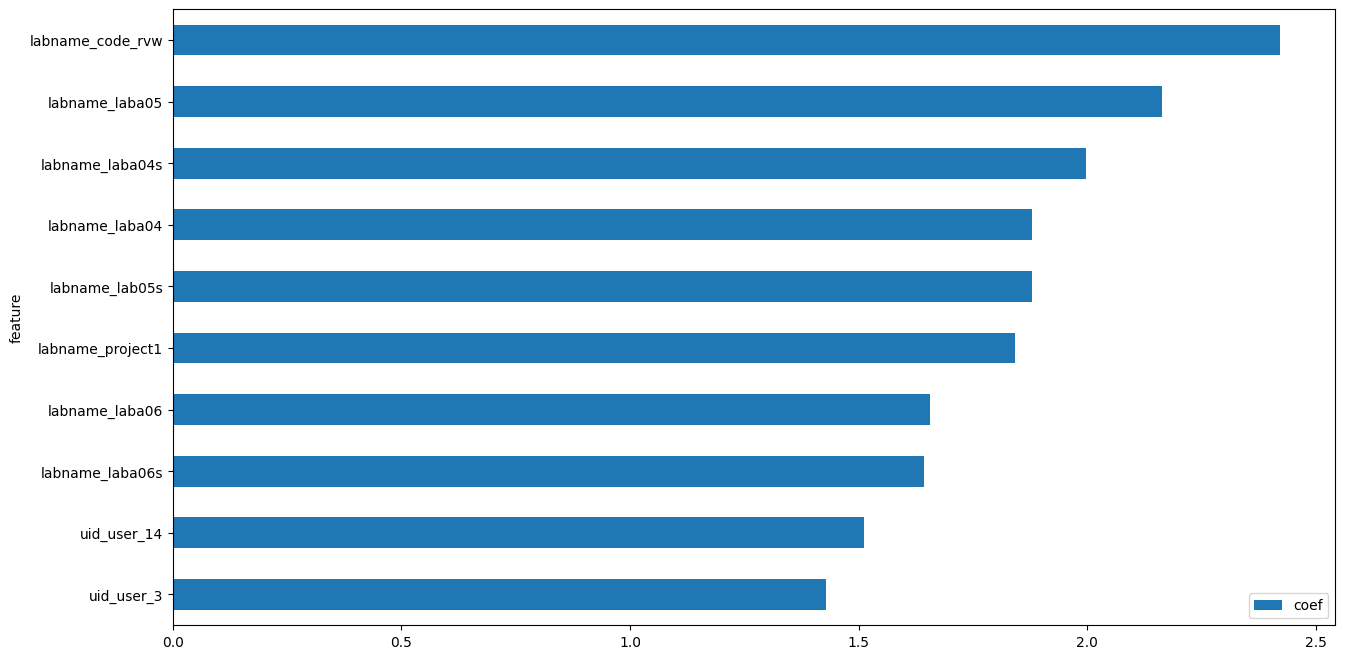

In [ ]:
handled_coefs = np.mean(np.abs(model.coefs_), axis=0)
draw_barh(model.feature_names_in_, handled_coefs)

### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

In [12]:
svc_model = OneVsRestClassifier(
    SVC(
        kernel='rbf',
        random_state=21,
        probability=True
    )
)

svc_model.fit(features, target)

,estimator,SVC(probabili...ndom_state=21)
,n_jobs,None
,verbose,0
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001


In [13]:
accuracy_score(df['weekday'], svc_model.predict(features))

0.6126927639383155

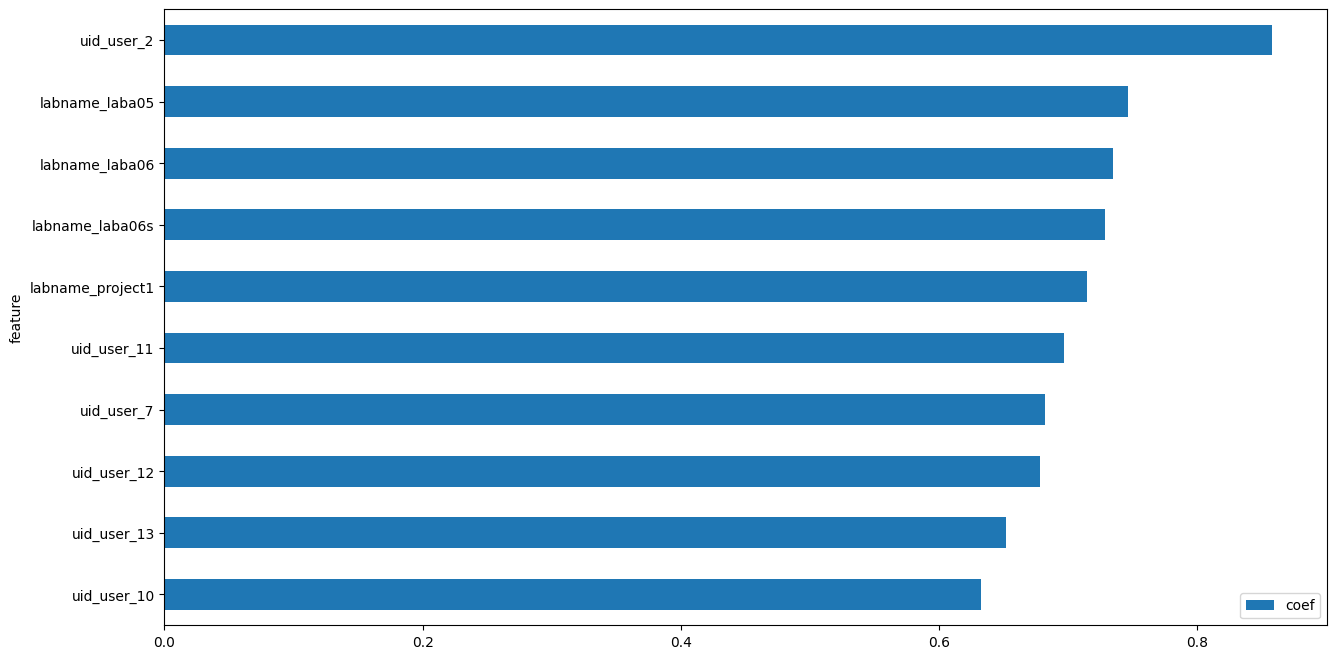

In [ ]:
coefs = np.vstack([estimator.coef_ for estimator in svc_model.estimators_])
in_model_features = svc_model.estimators_[0].feature_names_in_
draw_barh(in_model_features, coefs)

In [10]:
from sklearn.model_selection import GridSearchCV

In [13]:
param_grid = {
    'estimator__kernel' : ['linear', 'rbf', 'poly', 'sigmoid']
}

grid = GridSearchCV(svc_model, param_grid, scoring='accuracy')
grid.fit(features, target)

,estimator,OneVsRestClas...dom_state=21))
,param_grid,"{'estimator__kernel': ['linear', 'rbf', ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1.0


In [14]:
print(grid.best_params_)
print(grid.best_score_)

{'estimator__kernel': 'poly'}
0.5155338612540165


In [66]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.510426,0.024894,0.024728,0.003048,linear,{'estimator__kernel': 'linear'},0.304734,0.486647,0.421365,0.382789,0.237389,0.366585,0.087402,3
1,0.610972,0.036962,0.041935,0.002930,rbf,{'estimator__kernel': 'rbf'},0.298817,0.531157,0.569733,0.658754,0.391691,0.490030,0.128643,2
2,0.565242,0.030484,0.023460,0.001257,poly,{'estimator__kernel': 'poly'},0.325444,0.551929,0.602374,0.667656,0.430267,0.515534,0.122810,1
3,0.882692,0.039650,0.040252,0.002311,sigmoid,{'estimator__kernel': 'sigmoid'},0.245562,0.335312,0.270030,0.373887,0.287834,0.302525,0.046226,4


### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [15]:
from sklearn.tree import DecisionTreeClassifier

In [16]:
tree_model = DecisionTreeClassifier(
    max_depth=4,
    random_state=21
)

tree_model.fit(features, target)

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,21
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


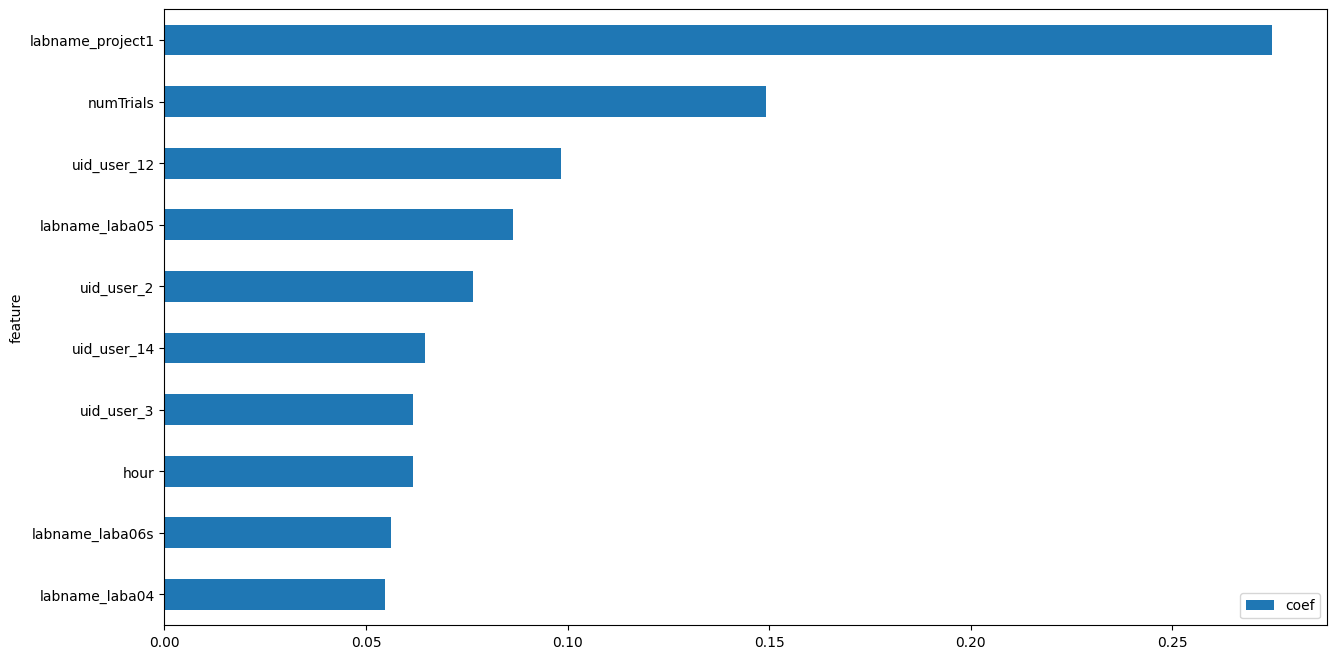

In [18]:
draw_barh(tree_model.feature_names_in_, tree_model.feature_importances_)

In [21]:
param_grid = ({
    'max_depth' : [4, 10, 21]
})

grid = GridSearchCV(
    tree_model,
    param_grid,
    scoring='accuracy'
)
grid.fit(features, target)

,estimator,DecisionTreeC...ndom_state=21)
,param_grid,"{'max_depth': [4, 10, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [22]:
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 21}
0.45973697610310255


### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=25,
    random_state=21
)

forest.fit(features, target)

,n_estimators,100
,criterion,'gini'
,max_depth,25
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


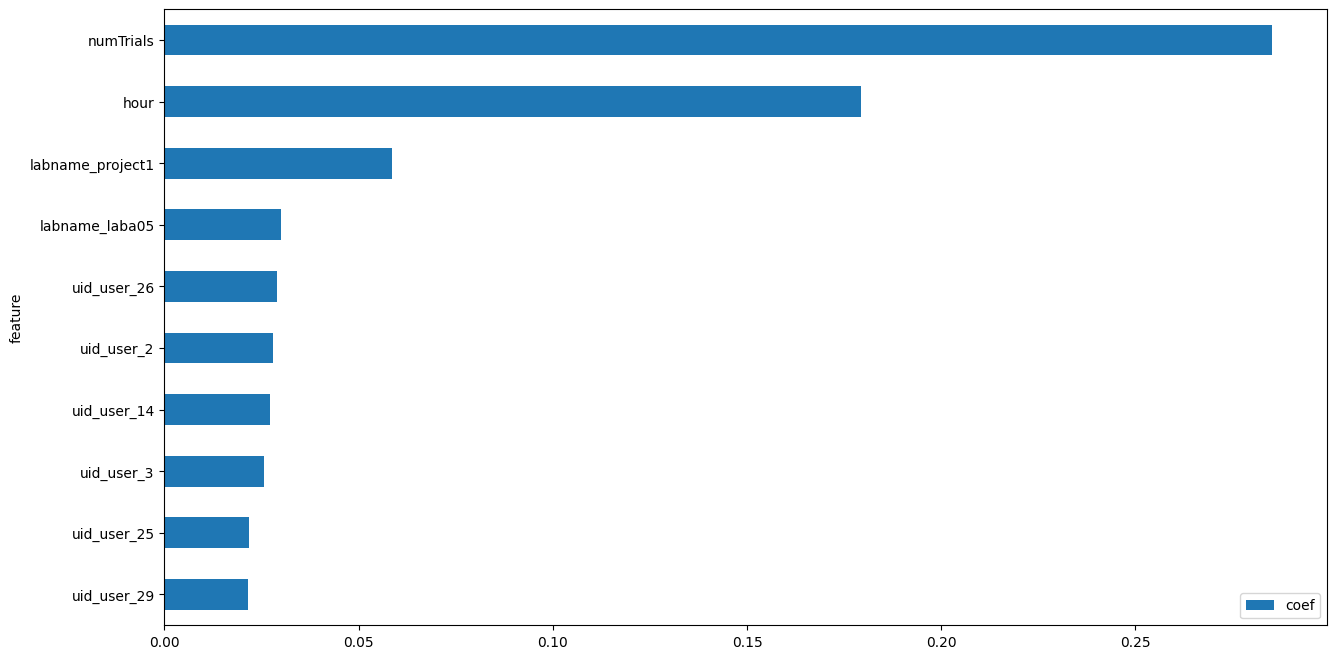

In [25]:
draw_barh(forest.feature_names_in_, forest.feature_importances_)

In [19]:
accuracy_score(forest.predict(features), target)

1.0